## Subword Tokenization

In [1]:
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer

In [2]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [3]:
# “ ”
text = "Tokenizing text is a core task of NLP."

In [4]:
# Tokenize the text
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [5]:
# Convert the token ids to tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [6]:
# Convert tokens to string
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [7]:
dir(tokenizer)[-25:]

['prepare_seq2seq_batch',
 'pretrained_init_configuration',
 'pretrained_vocab_files_map',
 'push_to_hub',
 'register_for_auto_class',
 'sanitize_special_tokens',
 'save_pretrained',
 'save_vocabulary',
 'sep_token',
 'sep_token_id',
 'set_truncation_and_padding',
 'slow_tokenizer_class',
 'special_tokens_map',
 'special_tokens_map_extended',
 'split_special_tokens',
 'tokenize',
 'train_new_from_iterator',
 'truncate_sequences',
 'truncation_side',
 'unk_token',
 'unk_token_id',
 'verbose',
 'vocab',
 'vocab_files_names',
 'vocab_size']

In [8]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)

30522
512


## Tokenizing the Whole Dataset

In [9]:
import datasets

In [10]:
emotions = datasets.load_dataset("emotion")

In [11]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


"""
This function applies the tokenizer to a batch of examples; padding=True will pad the
examples with zeros to the size of the longest one in a batch, and truncation=True
will truncate the examples to the model’s maximum context size.
"""

'\nThis function applies the tokenizer to a batch of examples; padding=True will pad the\nexamples with zeros to the size of the longest one in a batch, and truncation=True\nwill truncate the examples to the model’s maximum context size.\n'

In [12]:
dir(emotions)
emotions.column_names
emotions['train'][:2]

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

"""By default, the map() method operates individually on every example in the corpus,
so setting batched=True will encode the tweets in batches. Because we’ve set
batch_size=None, our tokenize() function will be applied on the full dataset as a
single batch. This ensures that the input tensors and attention masks have the same
shape globally, and we can see that this operation has added new input_ids and
attention_mask columns to the dataset:"""

print(emotions_encoded["train"].column_names)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

## Transformers as Feature Extractors

In [13]:
from transformers import AutoModel
import torch

In [14]:
model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

### Extracting the last hidden states

In [15]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
# shape [batch_size, n_tokens]

Input tensor shape: torch.Size([1, 6])


In [16]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():  # disable the automatic calculation of the gradient
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [17]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

Looking at the hidden state tensor, we see that it has the shape [batch_size,
n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
each of the 6 input tokens.

Now we know how to get the last hidden state for a single string; let’s do the same for
the whole dataset by creating a new hidden_state column that stores all these vectors.

In [18]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k: v.to(device) for k, v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [19]:
# convert the input_ids and attention_mask columns to the "torch" format
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# We can then go ahead and extract the hidden states across all splits in one go:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Creating a feature matrix

In [20]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the training set

In [21]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.186039,6.847160,0
1,-3.196278,5.688959,0
2,5.518668,3.488624,3
3,-2.471349,3.573476,2
4,-3.222794,3.846616,3


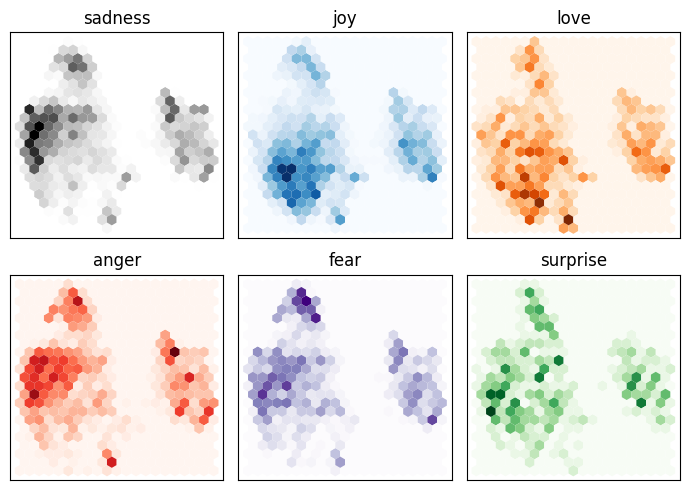

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Training a simple classifier

In [23]:
from sklearn.linear_model import LogisticRegression


# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

In [24]:
from sklearn.dummy import DummyClassifier


# comparing it against a simple baseline
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our
baseline.

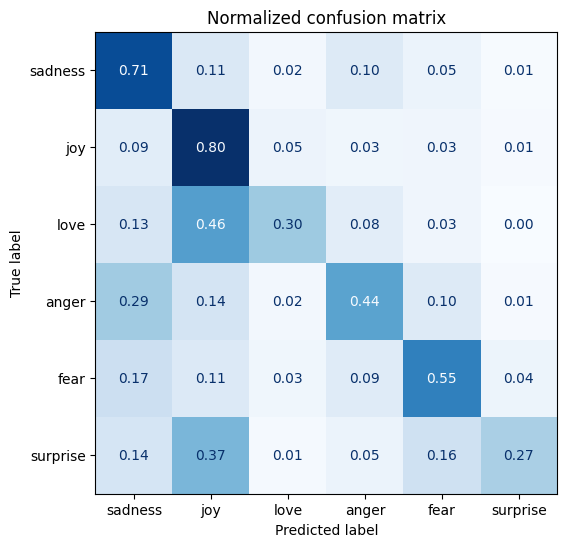

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees
with the observation we made when visualizing the embeddings. Also, love and
surprise are frequently mistaken for joy.

# Fine-Tuning Transformers

### Loading a pretrained model

Usamos AutoModelForSequenceClassification en vez de AutoModel porque queremos
hacer fine-tuning, en vez de usar el modelo como extractor de features.

In [26]:
from transformers import AutoModelForSequenceClassification

model_ckpt = "distilbert-base-uncased"
num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Defining the performance metrics

In [27]:
from sklearn.metrics import accuracy_score, f1_score


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

### Training the model

https://huggingface.co/docs/hub/security#user-access-tokens

In [28]:
from huggingface_hub import login
from dotenv import load_dotenv
import os

load_dotenv()

login(os.getenv("HUGGINGFACE_TOKEN"))

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to C:\Users\Agustin\.cache\huggingface\token
Login successful


In [29]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [30]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8359, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.31779396533966064, 'eval_accuracy': 0.906, 'eval_f1': 0.903932889325036, 'eval_runtime': 86.5274, 'eval_samples_per_second': 23.114, 'eval_steps_per_second': 0.37, 'epoch': 1.0}
{'loss': 0.2539, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.21518810093402863, 'eval_accuracy': 0.9265, 'eval_f1': 0.9262869891284342, 'eval_runtime': 78.4196, 'eval_samples_per_second': 25.504, 'eval_steps_per_second': 0.408, 'epoch': 2.0}
{'train_runtime': 7499.0203, 'train_samples_per_second': 4.267, 'train_steps_per_second': 0.067, 'train_loss': 0.5448914871215821, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5448914871215821, metrics={'train_runtime': 7499.0203, 'train_samples_per_second': 4.267, 'train_steps_per_second': 0.067, 'train_loss': 0.5448914871215821, 'epoch': 2.0})

We can take a more detailed look at the training metrics by calculating the confusion
matrix.

In [31]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

  0%|          | 0/32 [00:00<?, ?it/s]

{'test_loss': 0.21518810093402863,
 'test_accuracy': 0.9265,
 'test_f1': 0.9262869891284342,
 'test_runtime': 78.5884,
 'test_samples_per_second': 25.449,
 'test_steps_per_second': 0.407}

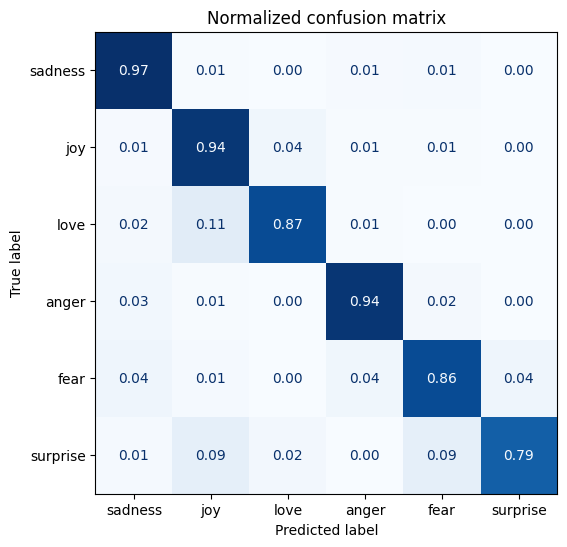

In [32]:
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

### Error analysis

In [33]:
from torch.nn.functional import cross_entropy

def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)


def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [34]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [35]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [36]:
# Let’s first have a look at the data samples with the highest losses:
display(df_test.sort_values("loss", ascending=False).head(10))

# Let’s also look at the predictions with the smallest loss:
display(df_test.sort_values("loss", ascending=True).head(10))

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.751966
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.636953
882,i feel badly about reneging on my commitment t...,love,sadness,5.548897
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.285065
1801,i feel that he was being overshadowed by the s...,love,sadness,5.182635
1509,i guess this is a memoir so it feels like that...,joy,fear,4.927809
1950,i as representative of everything thats wrong ...,surprise,sadness,4.868888
1111,im lazy my characters fall into categories of ...,joy,fear,4.757916
539,i feel i should say what i want since you are ...,joy,anger,4.738032
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.487717


,text,label,predicted_label,loss
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017317
69,i have no extra money im worried all of the ti...,sadness,sadness,0.017369
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017585
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.017755
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.017778
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017794
1310,i feel like an ungrateful asshole,sadness,sadness,0.017814
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.017891
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.017906
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.018174


### Saving and sharing the model

In [37]:
trainer.push_to_hub(commit_message="Training completed!")

'https://huggingface.co/agustinst1990/distilbert-base-uncased-finetuned-emotion/tree/main/'

In [1]:
"model URL: https://huggingface.co/agustinst1990/distilbert-base-uncased-finetuned-emotion"

'model URL: https://huggingface.co/agustinst1990/distilbert-base-uncased-finetuned-emotion'